### 0. Imports

In [1]:
import pandas as pd

import statsmodels
import pmdarima

from sklearn.preprocessing import MinMaxScaler
from sktime.utils.plotting import plot_series
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_absolute_error

### 1. Load and Prepare Data

In [2]:
demand = pd.read_csv('../data/exo_demand.csv')

# convert datetime string to period object
demand['utc'] = [pd.Period(period, freq='H') for period in demand['utc']]
demand

,utc,demand_MWh,weekend,tuesday,wednesday,thursday,friday,saturday,sunday,daily_high,daily_low
0,2015-07-22 08:00,1936.0,0,0,1,0,0,0,0,72.0,57.0
1,2015-07-22 09:00,1856.0,0,0,1,0,0,0,0,72.0,57.0
2,2015-07-22 10:00,1784.0,0,0,1,0,0,0,0,72.0,57.0
3,2015-07-22 11:00,1766.0,0,0,1,0,0,0,0,72.0,57.0
4,2015-07-22 12:00,1801.0,0,0,1,0,0,0,0,72.0,57.0
...,...,...,...,...,...,...,...,...,...,...,...
63293,2022-10-10 13:00,1991.0,0,0,0,0,0,0,0,NaN,NaN
63294,2022-10-10 14:00,2227.0,0,0,0,0,0,0,0,NaN,NaN
63295,2022-10-10 15:00,2391.0,0,0,0,0,0,0,0,NaN,NaN
63296,2022-10-10 16:00,2414.0,0,0,0,0,0,0,0,NaN,NaN


In [4]:
# mms fit transform demand
mmscaler = MinMaxScaler()
mms_demand = mmscaler.fit_transform(demand[['demand_MWh']])

# mms fit transform temps
mmscaler_temps = MinMaxScaler()
mms_temps = mmscaler_temps.fit_transform(demand[['daily_high', 'daily_low']])

# add to df
demand['mms_demand_MWh'] = mms_demand
demand[['mms_daily_high', 'mms_daily_low']] = mms_temps

In [6]:
demand.head()

,utc,demand_MWh,weekend,tuesday,wednesday,thursday,friday,saturday,sunday,daily_high,daily_low,mms_demand_MWh,mms_daily_high,mms_daily_low
0,2015-07-22 08:00,1936.0,0,0,1,0,0,0,0,72.0,57.0,0.192161,0.5,0.71875
1,2015-07-22 09:00,1856.0,0,0,1,0,0,0,0,72.0,57.0,0.166667,0.5,0.71875
2,2015-07-22 10:00,1784.0,0,0,1,0,0,0,0,72.0,57.0,0.143722,0.5,0.71875
3,2015-07-22 11:00,1766.0,0,0,1,0,0,0,0,72.0,57.0,0.137986,0.5,0.71875
4,2015-07-22 12:00,1801.0,0,0,1,0,0,0,0,72.0,57.0,0.149140,0.5,0.71875


### 2. Quick SARIMAX(1,0,0)(1,1,1)[24] Models for "Weekend"
- I originally tried the ARIMA(1,0,0)(1,0,0) specification that performed best for day-ahead forecasts without exogenous variables, but that model produced a downward trend in week-ahead predictions. This specification is based on discussion of a similar problem that I found [here](https://stats.stackexchange.com/questions/337766/statsmodels-sarimax-forecast-has-downward-slope).
- The best week-ahead SARIMA specification (ARIMA(2,1,2)(1,0,1)) is tested with a weekend dummy variable below in (4), but does not perform well.

**Week-Ahead:**

In [4]:
# setup y and X
y = demand.set_index('utc')['mms_demand_MWh']
X = demand.set_index('utc')['weekend']

# SAR forecasts for weeks 13 through 16
sar_x_preds_week = []

for n in range(4):
    y_12weektrain = y[168*n: 2016 + 168*n]
    X_12weektrain = X[168*n: 2016 + 168*n]
    
    sar_x_week = SARIMAX(y_12weektrain, exog=X_12weektrain,
                         order=(1,0,0), seasonal_order=(1,1,1,24),
                         enforce_stationarity=False)
    results = sar_x_week.fit()
    sar_x_preds_week.append(results.forecast(steps=168, exog=X[2016 + 168*n: 2016 + 168*(n+1)]))
    print(n)

0


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1
2
3


Fitting and forecasting for four weeks took about 2 minutes.

In [5]:
# convert to pandas series
sar_x_preds_week_flat = pd.Series([pred for l in mmscaler.inverse_transform(sar_x_preds_week) for pred in l], index=y.index[2016: 2016 + 168*4])

# reset demand values
y = demand.set_index('utc')['demand_MWh']

In [6]:
mean_absolute_error(y[2016: 2016 + 168*4], sar_x_preds_week_flat)

92.87828628654873

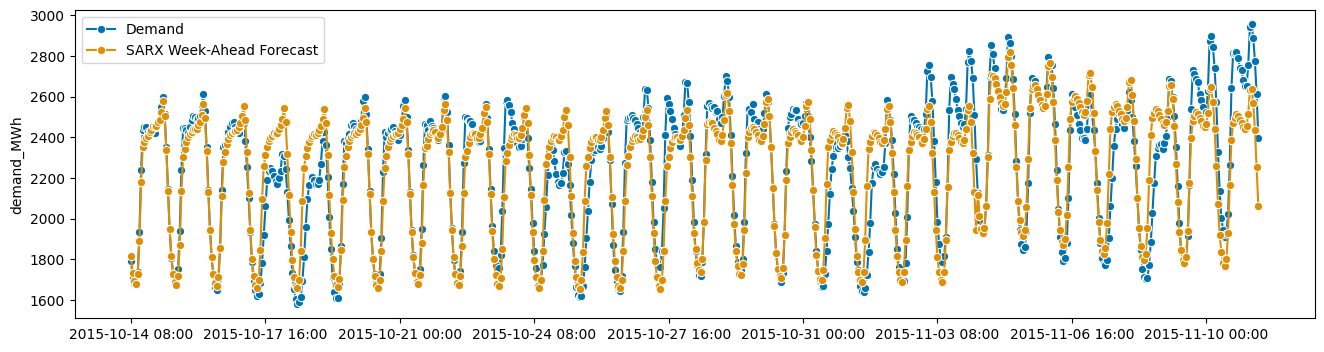

In [7]:
plot_series(y[2016: 2016 + 168*4], sar_x_preds_week_flat, labels=['Demand', 'SARX Week-Ahead Forecast']);

**Day-Ahead:**

In [21]:
# setup y and X
y = demand.set_index('utc')['mms_demand_MWh']
X = demand.set_index('utc')['weekend']

# SAR forecasts for days 85 through 112
sar_x_preds_day = []

for n in range(28):
    y_12weektrain = y[24*n: 2016 + 24*n]
    X_12weektrain = X[24*n: 2016 + 24*n]
    
    sar_x_day = SARIMAX(y_12weektrain, exog=X_12weektrain,
                         order=(1,0,0), seasonal_order=(1,1,1,24),
                         enforce_stationarity=False)
    results = sar_x_day.fit()
    sar_x_preds_day.append(results.forecast(steps=24, exog=X[2016 + 24*n: 2016 + 24*(n+1)]))
    print(n)

0
1


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2
3


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5
6


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8
9
10


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


11
12
13
14


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


15
16
17
18
19


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


20
21


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


22


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


23
24


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


25
26


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


27


In [24]:
# convert to pandas series
sar_x_preds_day_flat = pd.Series([pred for l in mmscaler.inverse_transform(sar_x_preds_day) for pred in l], index=y.index[2016: 2016 + 168*4])

# reset demand values
y = demand.set_index('utc')['demand_MWh']

In [25]:
mean_absolute_error(y[2016: 2016 + 168*4], sar_x_preds_day_flat)

82.63162741271984

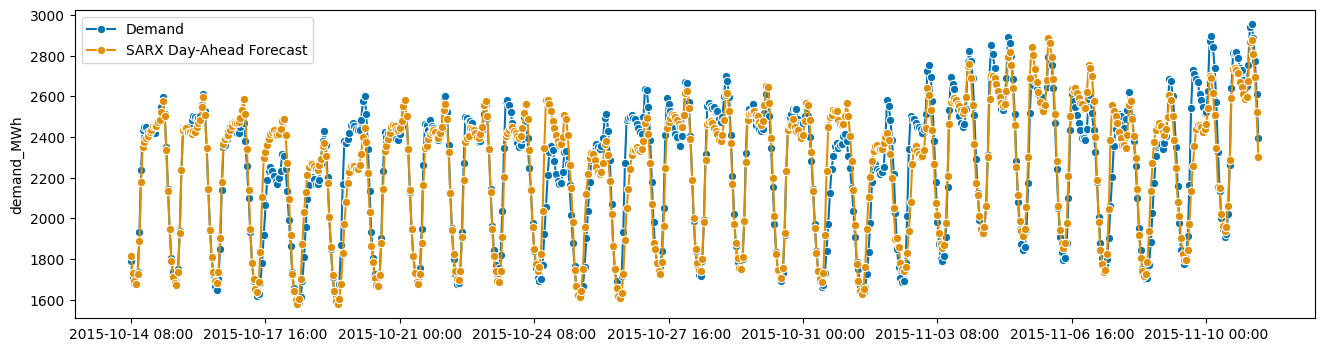

In [26]:
plot_series(y[2016: 2016 + 168*4], sar_x_preds_day_flat, labels=['Demand', 'SARX Day-Ahead Forecast']);

Both the week-ahead and day-ahead SARX models systematically over-estimate demand on Saturdays and under-estimate demand on Mondays, likely due to their reliance on the previous days' (Fridays' and Sundays') demands. This suggests that rather than a "weekend" dummy, which will account for Saturday the same as Sunday and Monday the same as Tuesday through Friday, we should use a "day of the week" dummy, so that "Saturday" can have a more negative effect than "Sunday" and "Monday" can have a more positive effect than the rest of the weekdays.

### 3. Quick SARIMAX(1,0,0)(1,1,1)[24] Models for "Day-of-Week"

**Week-Ahead:**

In [5]:
# setup y and X
y = demand.set_index('utc')['mms_demand_MWh']
X = demand.set_index('utc')[['tuesday', 'wednesday', 'thursday',
                             'friday', 'saturday', 'sunday']]

# SARIMAX forecasts for weeks 13 through 16
sar_dow_preds_week = []

for n in range(4):
    y_12weektrain = y[168*n: 2016 + 168*n]
    X_12weektrain = X[168*n: 2016 + 168*n]
    
    sar_dow_week = SARIMAX(y_12weektrain, exog=X_12weektrain,
                         order=(1,0,0), seasonal_order=(1,1,1,24),
                         enforce_stationarity=False)
    results = sar_dow_week.fit()
    sar_dow_preds_week.append(results.forecast(steps=168, exog=X[2016 + 168*n: 2016 + 168*(n+1)]))
    print(n)

C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3


In [6]:
# convert to pandas series
sar_dow_preds_week_flat = pd.Series([pred for l in mmscaler.inverse_transform(sar_dow_preds_week) for pred in l], index=y.index[2016: 2016 + 168*4])

# reset demand values
y = demand.set_index('utc')['demand_MWh']

In [7]:
mean_absolute_error(y[2016: 2016 + 168*4], sar_dow_preds_week_flat)

104.92980542987395

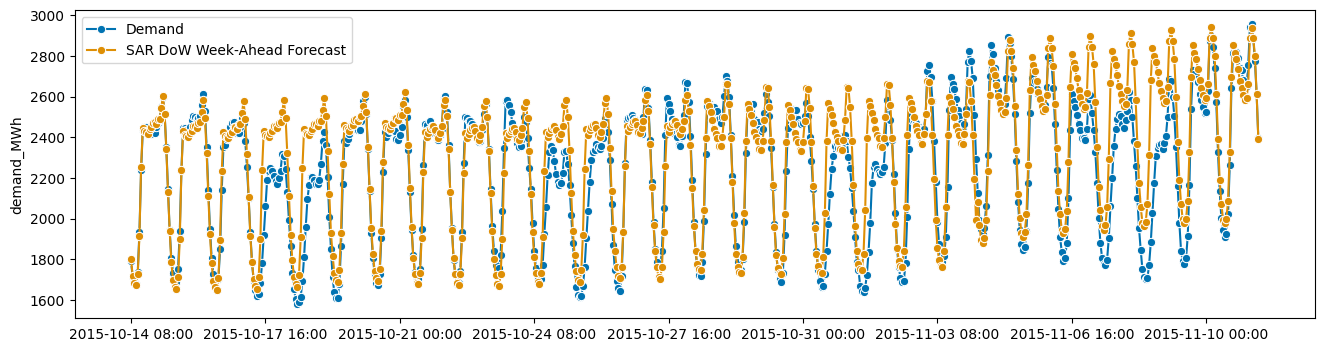

In [8]:
plot_series(y[2016: 2016 + 168*4], sar_dow_preds_week_flat, labels=['Demand', 'SAR DoW Week-Ahead Forecast']);

**Day-Ahead:**

In [8]:
# setup y and X
y = demand.set_index('utc')['mms_demand_MWh']
X = demand.set_index('utc')[['tuesday', 'wednesday', 'thursday',
                             'friday', 'saturday', 'sunday']]

# SARIMAX forecasts for days 85 through 112
sar_dow_preds_day = []

for n in range(28):
    y_12weektrain = y[24*n: 2016 + 24*n]
    X_12weektrain = X[24*n: 2016 + 24*n]
    
    sar_dow_day = SARIMAX(y_12weektrain, exog=X_12weektrain,
                          order=(1,0,0), seasonal_order=(1,1,1,24),
                          enforce_stationarity=False)
    results = sar_dow_day.fit()
    sar_dow_preds_day.append(results.forecast(steps=24, exog=X[2016 + 24*n: 2016 + 24*(n+1)]))
    print(n)

C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


10


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


11


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


12


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


13


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


14


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


15


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


16


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


17


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


18


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


19


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


20


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


21


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


22


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


23


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


24


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


25


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


26


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


27


In [9]:
# convert to pandas series
sar_dow_preds_day_flat = pd.Series([pred for l in mmscaler.inverse_transform(sar_dow_preds_day) for pred in l], index=y.index[2016: 2016 + 168*4])

# reset demand values
y = demand.set_index('utc')['demand_MWh']

In [10]:
mean_absolute_error(y[2016: 2016 + 168*4], sar_dow_preds_day_flat)

85.41396750124662

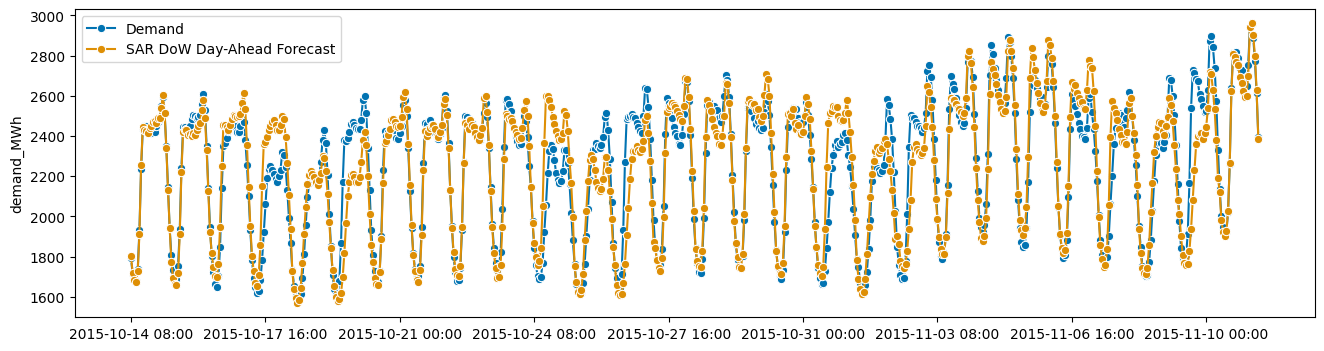

In [11]:
plot_series(y[2016: 2016 + 168*4], sar_dow_preds_day_flat, labels=['Demand', 'SAR DoW Day-Ahead Forecast']);

Using dummies for day-of-week instead of weekend does not seem to improve weekend forecasts, makes worse forecasts overall, and takes longer. It is unclear how to best account for weekly periodicity in a SARIMAX model. Going forward, using a simple weekend dummy will be preferred.

### 4. Quick SARIMAX(2,1,2)(1,0,1)[24] Models with Weekend Dummy

In [12]:
# setup y and X
y = demand.set_index('utc')['mms_demand_MWh']
X = demand.set_index('utc')['weekend']

# SAR forecasts for weeks 13 through 16
sarima_x_preds_week = []

for n in range(4):
    y_12weektrain = y[168*n: 2016 + 168*n]
    X_12weektrain = X[168*n: 2016 + 168*n]
    
    sarima_x_week = SARIMAX(y_12weektrain, exog=X_12weektrain,
                            order=(2,1,2), seasonal_order=(1,0,1,24),
                            enforce_stationarity=False)
    results = sarima_x_week.fit()
    sarima_x_preds_week.append(results.forecast(steps=168, exog=X[2016 + 168*n: 2016 + 168*(n+1)]))
    print(n)

C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3


In [13]:
# convert to pandas series
sarima_x_preds_week_flat = pd.Series([pred for l in mmscaler.inverse_transform(sarima_x_preds_week) for pred in l], index=y.index[2016: 2016 + 168*4])

# reset demand values
y = demand.set_index('utc')['demand_MWh']

In [14]:
mean_absolute_error(y[2016: 2016 + 168*4], sarima_x_preds_week_flat)

151.64709729135495

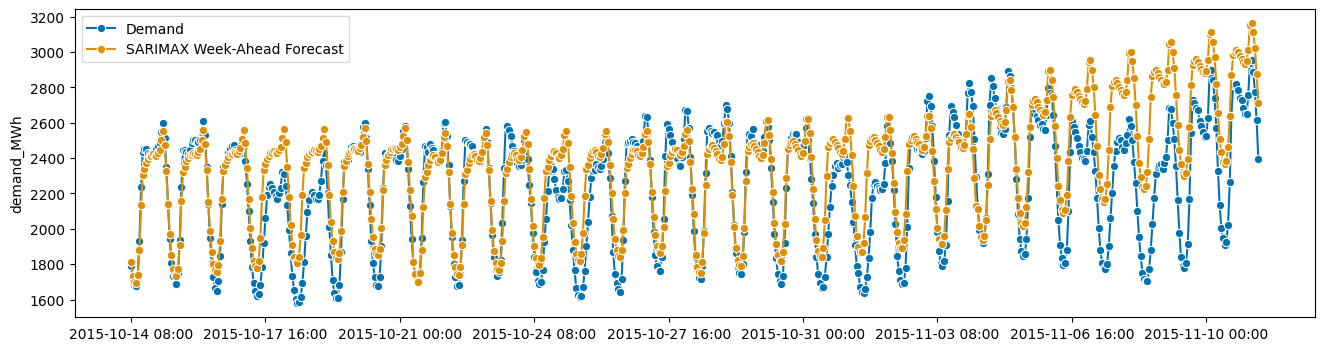

In [15]:
plot_series(y[2016: 2016 + 168*4], sarima_x_preds_week_flat, labels=['Demand', 'SARIMAX Week-Ahead Forecast']);

This ARIMA specification performs much worse than the SARX (ARIMA(1,0,0)(1,1,1)[24]) specification. 

### 5. ARIMA(1,0,0)(1,1,1)[24] with Weekend Dummy and Daily Temperature

**Week-Ahead:**

In [7]:
# setup y and X
y = demand.set_index('utc')['mms_demand_MWh']
X = demand.set_index('utc')[['weekend', 'mms_daily_high', 'mms_daily_low']]

# SARIMAX forecasts for weeks 13 through 16
sar_wkendtemp_preds_week = []

for n in range(4):
    y_12weektrain = y[168*n: 2016 + 168*n]
    X_12weektrain = X[168*n: 2016 + 168*n]
    
    sar_wkendtemp_week = SARIMAX(y_12weektrain, exog=X_12weektrain,
                                 order=(1,0,0), seasonal_order=(1,1,1,24),
                                 enforce_stationarity=False)
    results = sar_wkendtemp_week.fit()
    sar_wkendtemp_preds_week.append(results.forecast(steps=168, exog=X[2016 + 168*n: 2016 + 168*(n+1)]))
    print(n)

C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3


In [8]:
# convert to pandas series
sar_wkendtemp_preds_week_flat = pd.Series([pred for l in mmscaler.inverse_transform(sar_wkendtemp_preds_week) for pred in l], index=y.index[2016: 2016 + 168*4])

# reset demand values
y = demand.set_index('utc')['demand_MWh']

In [9]:
mean_absolute_error(y[2016: 2016 + 168*4], sar_wkendtemp_preds_week_flat)

112.04234257388073

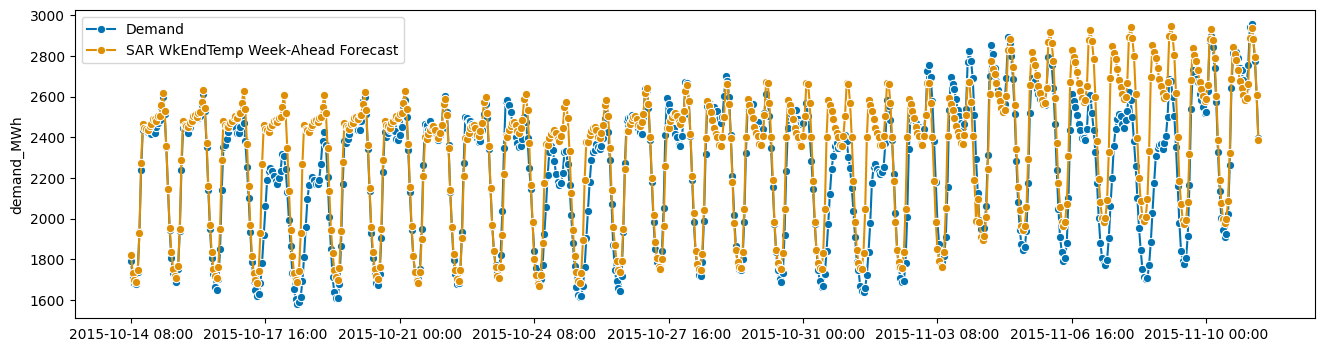

In [10]:
plot_series(y[2016: 2016 + 168*4], sar_wkendtemp_preds_week_flat, labels=['Demand', 'SAR WkEndTemp Week-Ahead Forecast']);

**Day-Ahead:**

In [11]:
# setup y and X
y = demand.set_index('utc')['mms_demand_MWh']
X = demand.set_index('utc')[['weekend', 'mms_daily_high', 'mms_daily_low']]

# SARIMAX forecasts for days 85 through 112
sar_wkendtemp_preds_day = []

for n in range(28):
    y_12weektrain = y[24*n: 2016 + 24*n]
    X_12weektrain = X[24*n: 2016 + 24*n]
    
    sar_wkendtemp_day = SARIMAX(y_12weektrain, exog=X_12weektrain,
                                order=(1,0,0), seasonal_order=(1,1,1,24),
                                enforce_stationarity=False)
    results = sar_wkendtemp_day.fit()
    sar_wkendtemp_preds_day.append(results.forecast(steps=24, exog=X[2016 + 24*n: 2016 + 24*(n+1)]))
    print(n)

C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9
10


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


11


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


12


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


13


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


14


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


15


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


16


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


17


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


18


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


19


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


20


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


21
22


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


23


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


24


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


25


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


26
27


In [12]:
# convert to pandas series
sar_wkendtemp_preds_day_flat = pd.Series([pred for l in mmscaler.inverse_transform(sar_wkendtemp_preds_day) for pred in l], index=y.index[2016: 2016 + 168*4])

# reset demand values
y = demand.set_index('utc')['demand_MWh']

In [13]:
mean_absolute_error(y[2016: 2016 + 168*4], sar_wkendtemp_preds_day_flat)

82.04207850313358

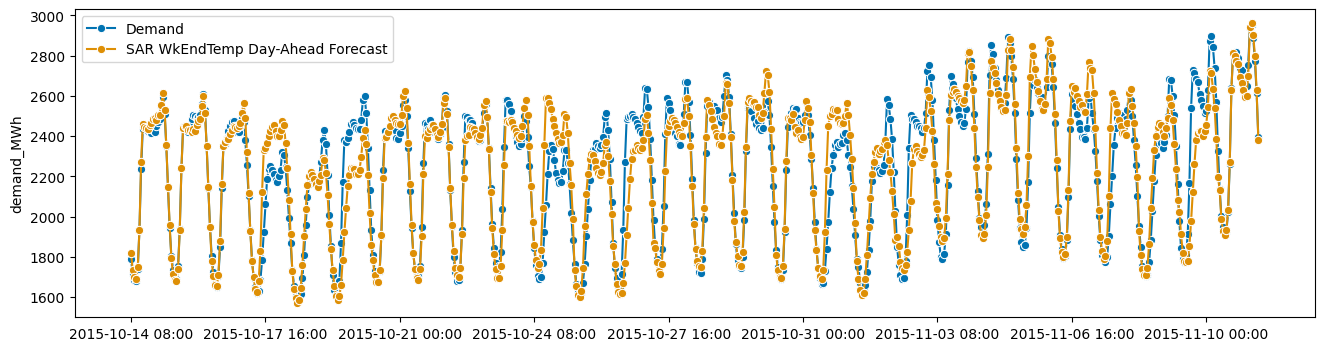

In [14]:
plot_series(y[2016: 2016 + 168*4], sar_wkendtemp_preds_day_flat, labels=['Demand', 'SAR WkEndTemp Day-Ahead Forecast']);

The SAR day-ahead model with weekend dummy and daily high and low temperatures at PDX performs slightly better than without the version without the temperatures. It exhibits the same problem forecasting Saturdays and Mondays as similar models with the weekend dummy.

#### Aside: Confirming Poor Performance of DoW Dummies on 12-week Forecasting Period

In [9]:
# setup y and X
y = demand.set_index('utc')['mms_demand_MWh']
X = demand.set_index('utc')[['tuesday', 'wednesday', 'thursday',
                             'friday', 'saturday', 'sunday']]

# SAR forecasts for weeks 17 through 28
sar_dow_preds_weeks17_28 = []

for n in range(12):
    y_12weektrain = y[168*n + 168*4: 2016 + 168*n + 168*4]
    X_12weektrain = X[168*n + 168*4: 2016 + 168*n + 168*4]
    
    sar_dow_week = SARIMAX(y_12weektrain, exog=X_12weektrain,
                         order=(1,0,0), seasonal_order=(1,1,1,24),
                         enforce_stationarity=False)
    results = sar_dow_week.fit()
    sar_dow_preds_weeks17_28.append(results.forecast(steps=168, exog=X[2016 + 168*n + 168*4: 2016 + 168*(n+1) + 168*4]))
    print(n)

C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


0


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


6


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


7


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


8


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


9


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


10


C:\Users\Graham\anaconda3\envs\sktimeenv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


11


In [12]:
# convert to pandas series
sar_dow_preds_weeks17_28_flat = pd.Series([pred for l in mmscaler.inverse_transform(sar_dow_preds_weeks17_28) for pred in l],
                                          index=y.index[2016 + 168*4: 2016 + 168*4 + 168*12])

# reset demand values
y = demand.set_index('utc')['demand_MWh']

In [13]:
mean_absolute_error(y[2016 + 168*4: 2016 + 168*4 + 168*12], sar_dow_preds_weeks17_28_flat)

170.2953186889818

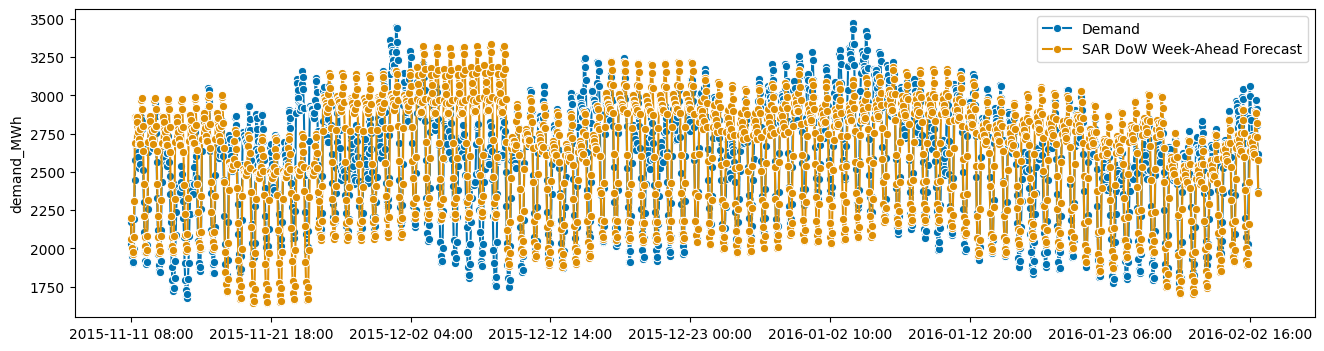

In [14]:
plot_series(y[2016 + 168*4: 2016 + 168*4 + 168*12], sar_dow_preds_weeks17_28_flat, labels=['Demand', 'SAR DoW Week-Ahead Forecast']);

The model clearly performs better in some weeks than others. The 12 forecasted weeks appear distinctly in the graph. The last four weeks are among the best-forecasted.